In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


🧪 TESTING MODEL SAVING FUNCTIONALITY
✅ Model saving test PASSED
✅ Model loading test PASSED
✅ Test cleanup completed

✅ Churn Prediction Pipeline Ready!
📝 To run: modeler, preprocessor = run_churn_prediction_pipeline('your_dataset.csv')

📋 Sample customer data for testing:
  customerID: 1234-ABC
  gender: Male
  SeniorCitizen: 0
  Partner: Yes
  Dependents: No
  tenure: 12
  PhoneService: Yes
  MultipleLines: No
  InternetService: DSL
  OnlineSecurity: Yes
  OnlineBackup: No
  DeviceProtection: No
  TechSupport: Yes
  StreamingTV: No
  StreamingMovies: No
  Contract: Month-to-month
  PaperlessBilling: Yes
  PaymentMethod: Electronic check
  MonthlyCharges: 60.0
  TotalCharges: 720.0

💡 Usage Instructions:
1. First run: modeler, preprocessor = run_churn_prediction_pipeline('your_dataset.csv')
2. Then predict: result = predict_churn(sample_customer)
3. Check saved files with: os.listdir('.')

🛠️ Additional utility functions available:
  - list_saved_files(): Show all saved .pkl files
  -

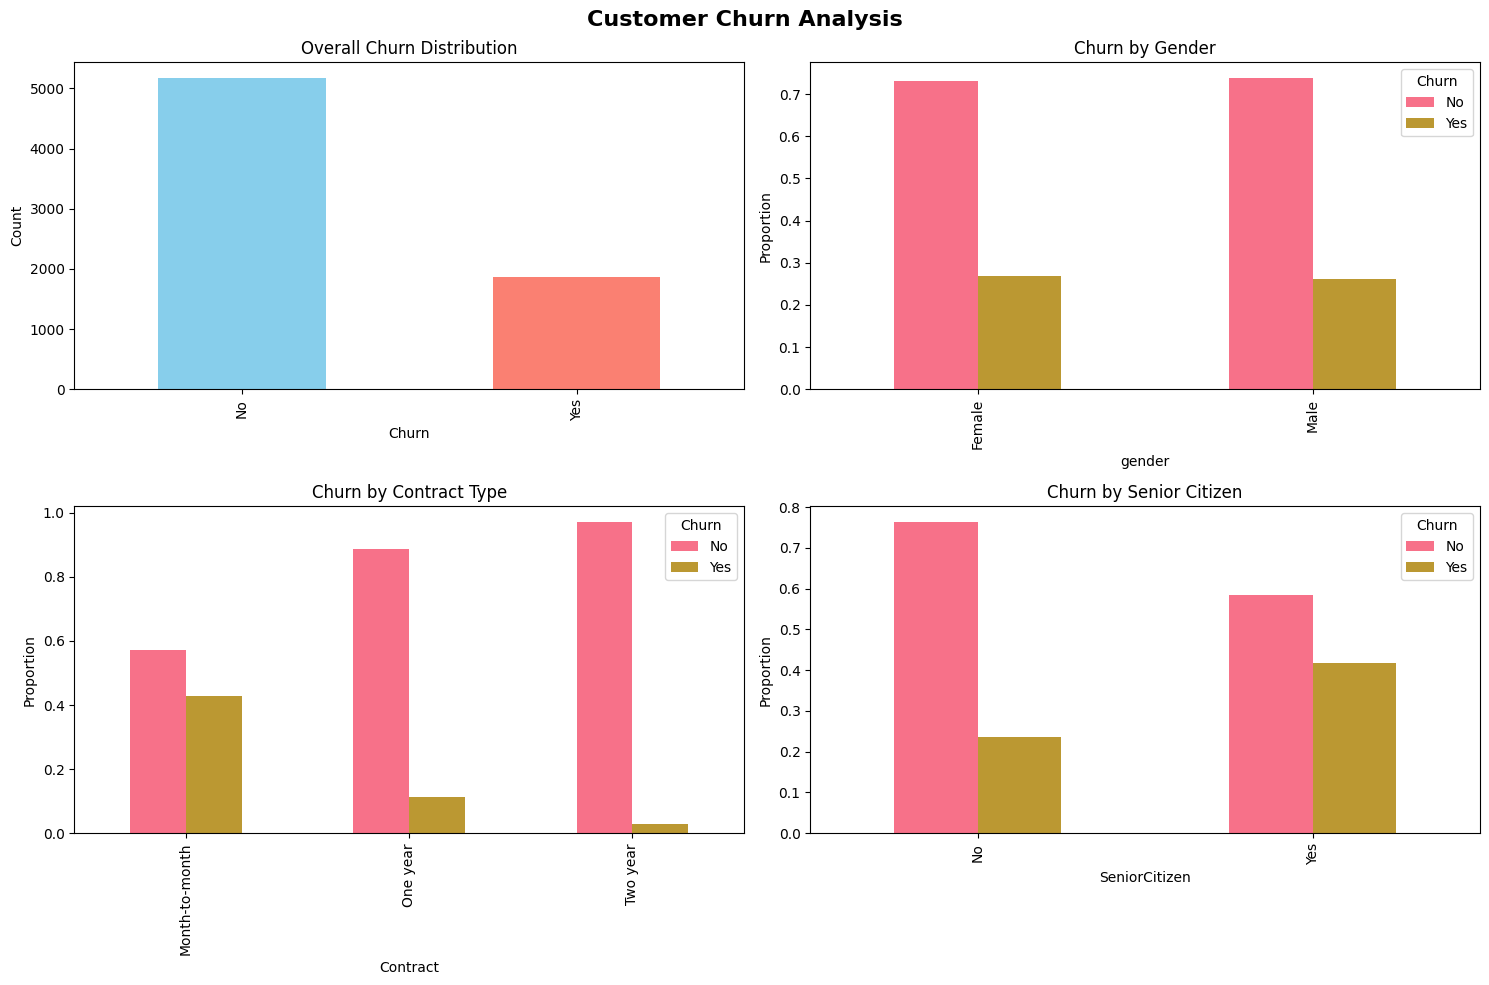

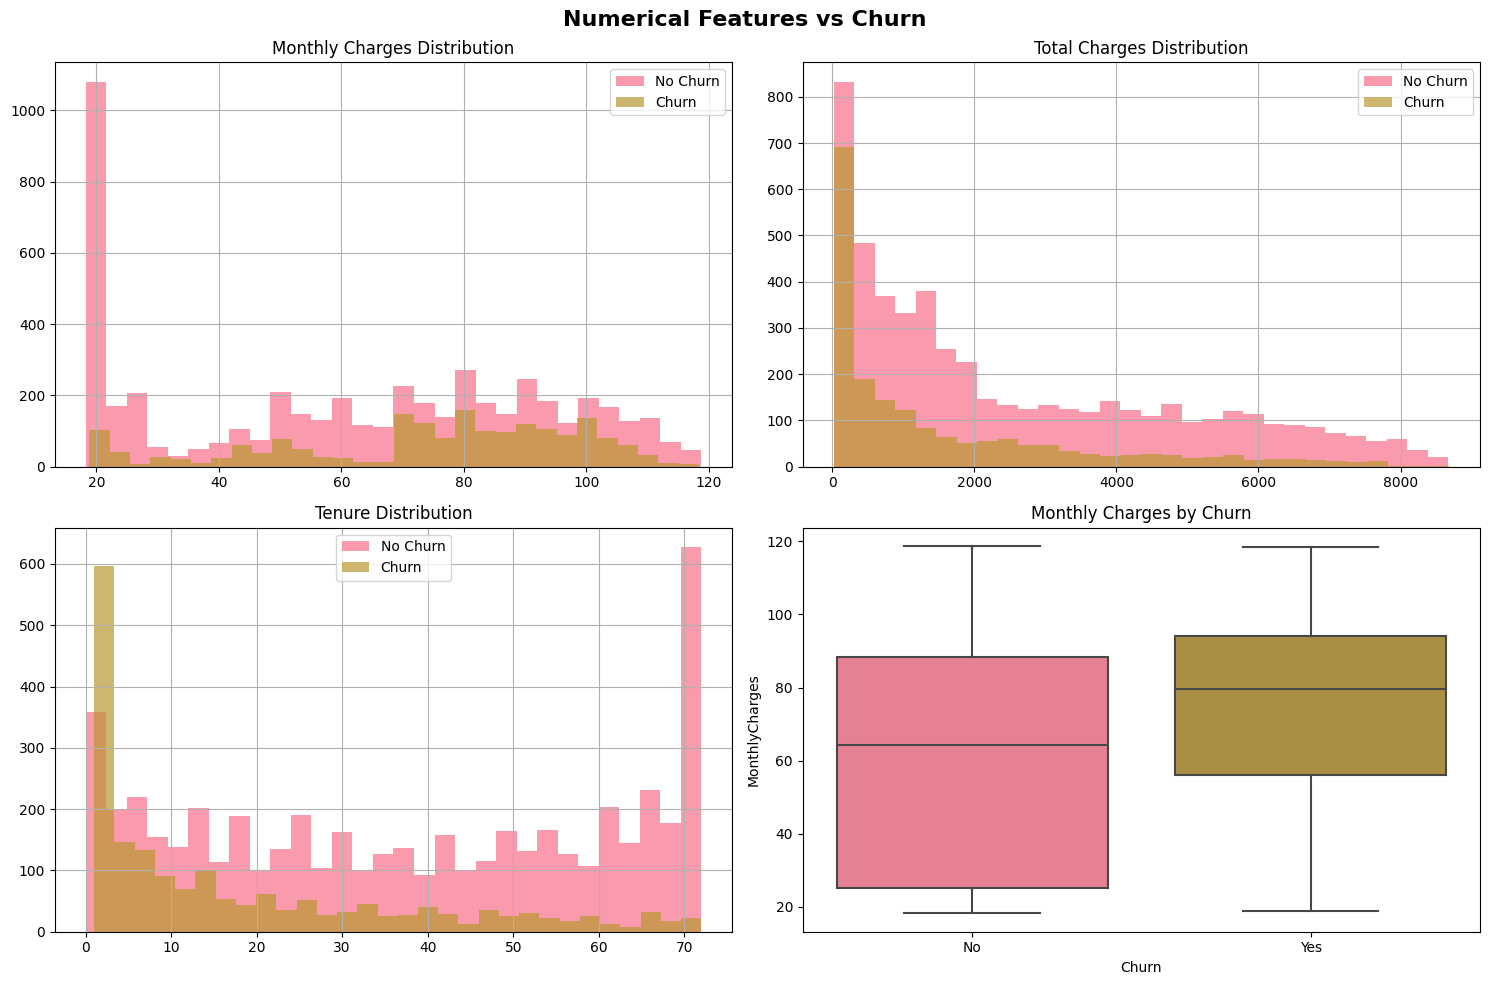


🔧 FEATURE ENGINEERING...
✅ New features created:
- tenure_group, AvgMonthlySpend, ServiceCount, HighValue

🔄 ENCODING CATEGORICAL VARIABLES...
✅ Encoded 17 categorical variables
✅ Scaled 5 numerical features


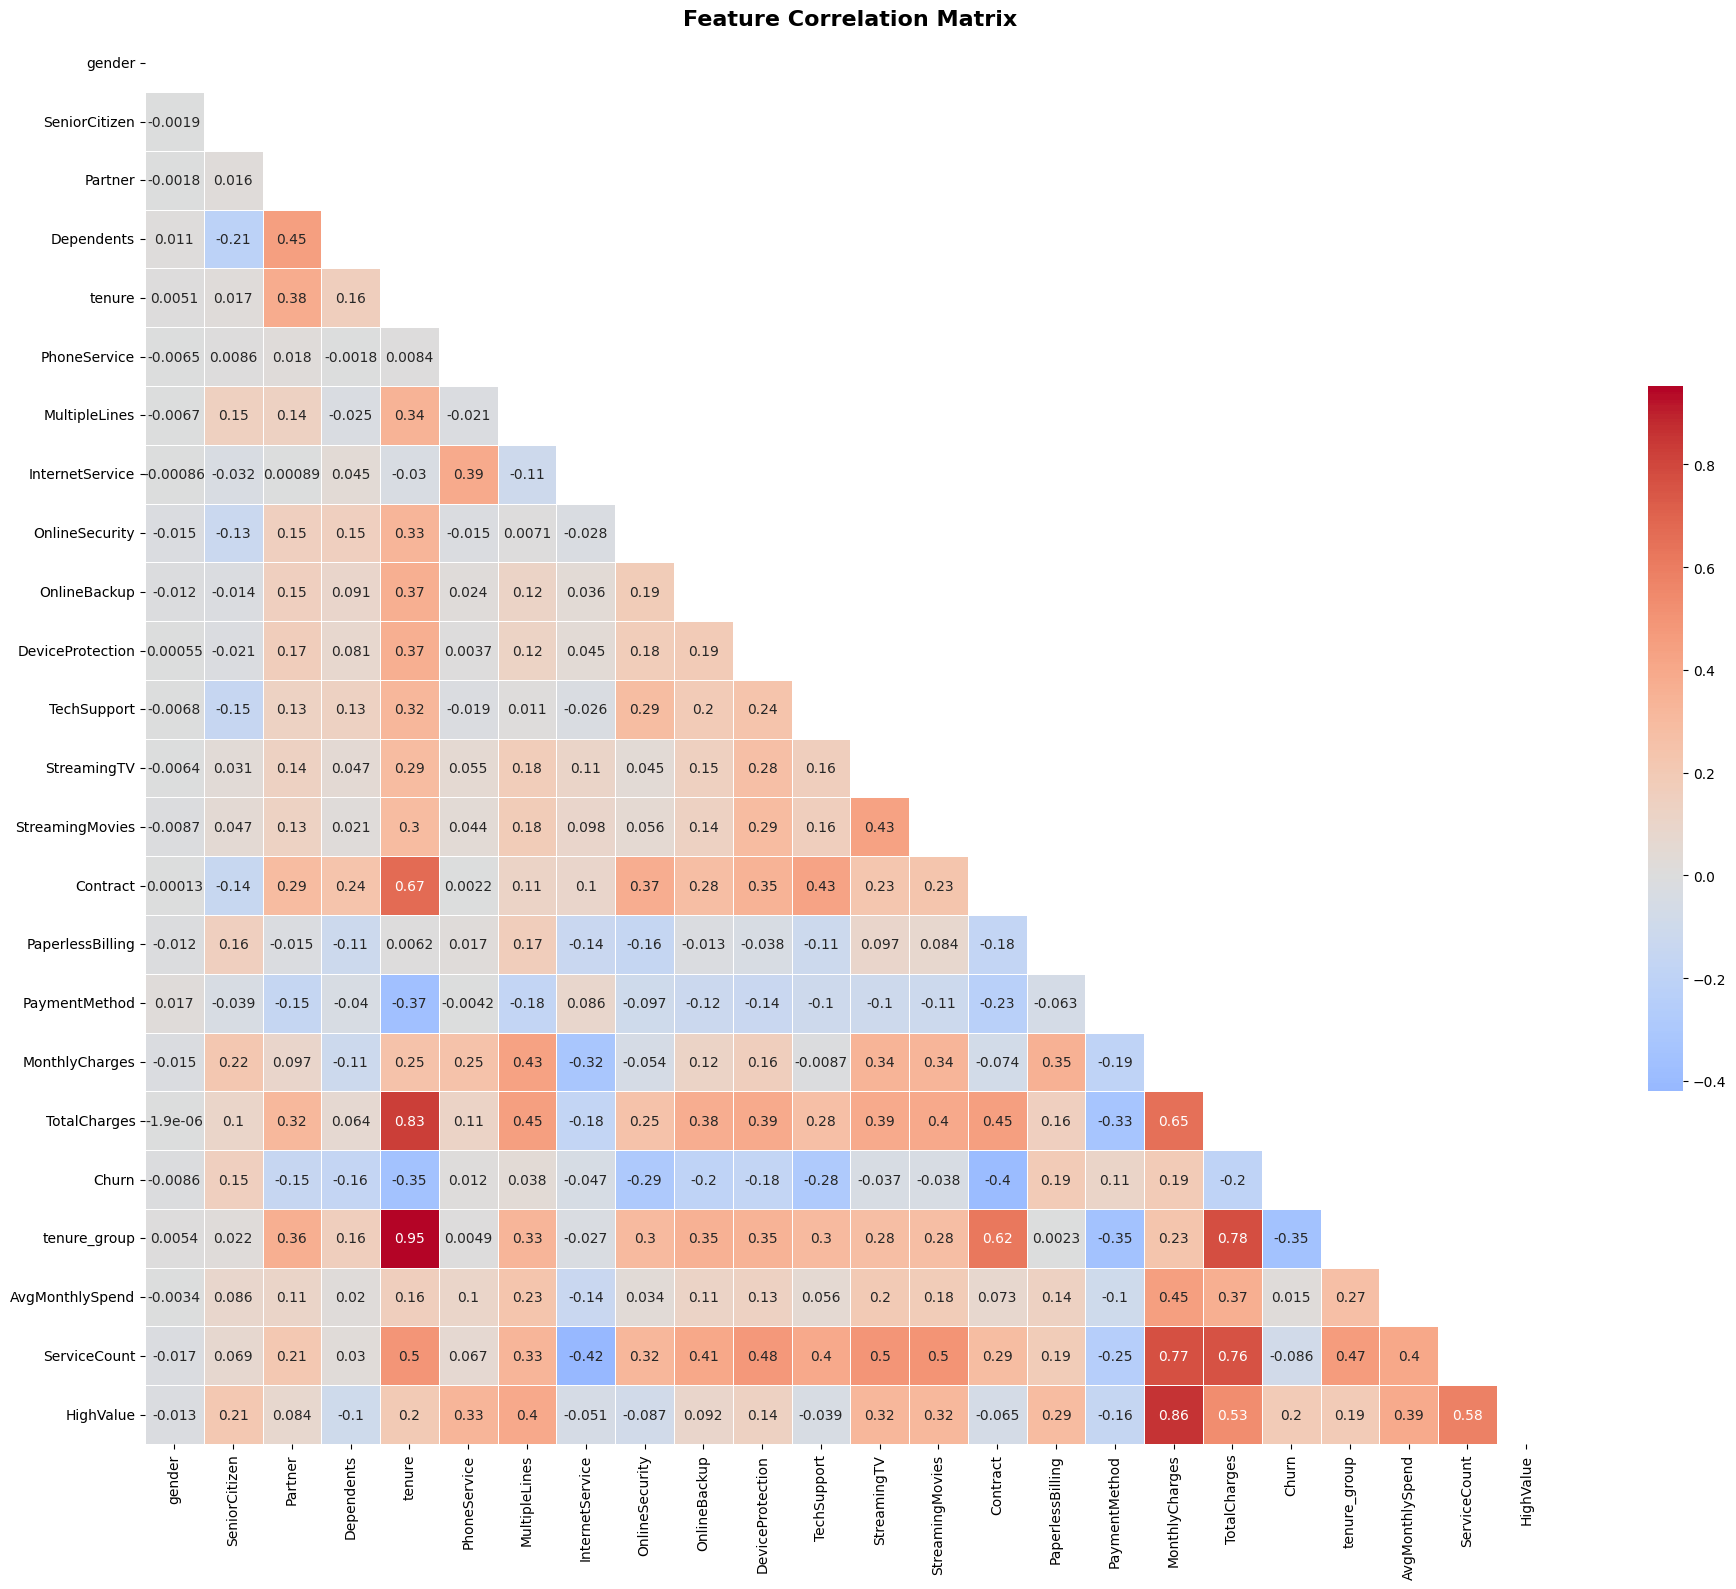


🔗 TOP CORRELATIONS WITH CHURN:
Churn             1.000000
Contract          0.396713
tenure            0.352229
tenure_group      0.347829
OnlineSecurity    0.289309
TechSupport       0.282492
TotalCharges      0.199037
HighValue         0.195663
OnlineBackup      0.195525
MonthlyCharges    0.193356
Name: Churn, dtype: float64

🎯 PREPARING DATA FOR MODELING...
📝 Features to be used: 23
✅ Training set: (5634, 23)
✅ Test set: (1409, 23)

🤖 TRAINING MODELS...

🔄 Training Logistic Regression...
✅ Logistic Regression - AUC: 0.8456

🔄 Training Random Forest...
✅ Random Forest - AUC: 0.8219

🔄 Training XGBoost...
✅ XGBoost - AUC: 0.8141

🔄 Training LightGBM...
✅ LightGBM - AUC: 0.8305

🔍 Successfully trained 4 models: ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']

📈 MODEL EVALUATION RESULTS
                 Model  Train Accuracy  Test Accuracy  AUC Score  CV AUC Mean  \
0  Logistic Regression          0.8064         0.8048     0.8456       0.8470   
1        Random Forest  

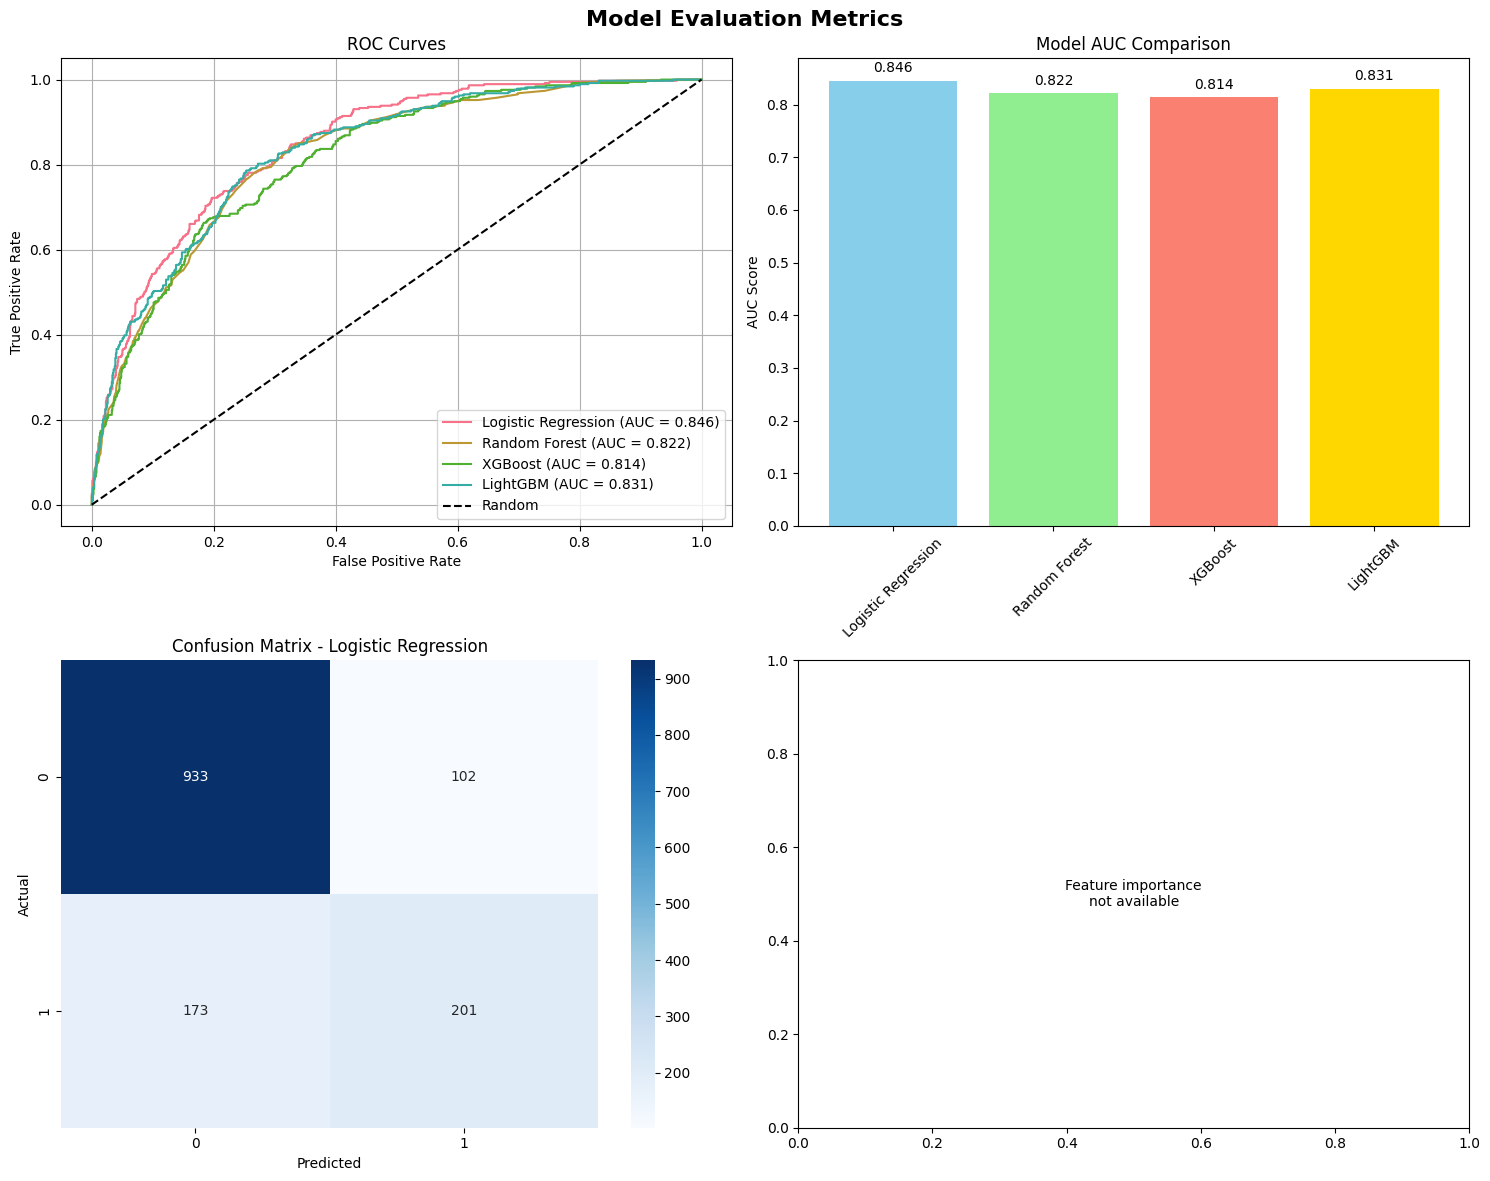


📋 DETAILED CLASSIFICATION REPORTS

Logistic Regression:
----------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409


Random Forest:
----------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409


XGBoost:
----------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.60      0.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import lightgbm as lgb
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# ====================================================================
# 1. DATA PREPROCESSING CLASS
# ====================================================================

class DataPreprocessor:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.feature_names = None  # Store feature names for consistency
        
    def load_data(self, file_path):
        """Load the Telco dataset"""
        try:
            df = pd.read_csv(file_path)
            print(f"✅ Dataset loaded successfully!")
            print(f"Shape: {df.shape}")
            return df
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            return None
    
    def clean_data(self, df):
        """Clean and preprocess the data"""
        print("\n🧹 CLEANING DATA...")
        
        df_clean = df.copy()
        
        # Handle TotalCharges - convert to numeric
        df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
        
        # Fill missing TotalCharges with median
        df_clean['TotalCharges'].fillna(df_clean['TotalCharges'].median(), inplace=True)
        
        # Convert SeniorCitizen to string for consistency
        df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
        
        print(f"Missing values after cleaning:")
        missing_vals = df_clean.isnull().sum()[df_clean.isnull().sum() > 0]
        if len(missing_vals) == 0:
            print("No missing values found!")
        else:
            print(missing_vals)
        
        return df_clean
    
    def feature_engineering(self, df):
        """Create new features"""
        print("\n🔧 FEATURE ENGINEERING...")
        
        df_fe = df.copy()
        
        # Tenure groups
        df_fe['tenure_group'] = pd.cut(df_fe['tenure'], 
                                     bins=[0, 12, 24, 48, np.inf], 
                                     labels=['0-12', '12-24', '24-48', '48+'])
        
        # Average monthly spend
        df_fe['AvgMonthlySpend'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)
        
        # Service count
        service_cols = ['PhoneService', 'InternetService', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                       'StreamingTV', 'StreamingMovies']
        
        df_fe['ServiceCount'] = 0
        for col in service_cols:
            if col in df_fe.columns:
                df_fe['ServiceCount'] += (df_fe[col] == 'Yes').astype(int)
        
        # Contract value indicator
        df_fe['HighValue'] = (df_fe['MonthlyCharges'] > df_fe['MonthlyCharges'].median()).astype(int)
        
        print("✅ New features created:")
        print("- tenure_group, AvgMonthlySpend, ServiceCount, HighValue")
        
        return df_fe
    
    def encode_features(self, df):
        """Encode categorical variables and scale numerical features"""
        print("\n🔄 ENCODING CATEGORICAL VARIABLES...")
        
        df_encoded = df.copy()
        
        # Columns to encode
        categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                          'PhoneService', 'MultipleLines', 'InternetService',
                          'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                          'TechSupport', 'StreamingTV', 'StreamingMovies',
                          'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']
        
        for col in categorical_cols:
            if col in df_encoded.columns:
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
                self.label_encoders[col] = le
        
        # Encode target
        le_target = LabelEncoder()
        if 'Churn' in df_encoded.columns:
            df_encoded['Churn'] = le_target.fit_transform(df_encoded['Churn'])
            self.label_encoders['Churn'] = le_target
        
        # Scale numerical features - FIX: Use fit_transform correctly
        numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'ServiceCount']
        
        # Only scale columns that exist
        existing_numerical_cols = [col for col in numerical_cols if col in df_encoded.columns]
        
        if existing_numerical_cols:
            df_encoded[existing_numerical_cols] = self.scaler.fit_transform(df_encoded[existing_numerical_cols])
        
        print(f"✅ Encoded {len([col for col in categorical_cols if col in df_encoded.columns])} categorical variables")
        print(f"✅ Scaled {len(existing_numerical_cols)} numerical features")
        
        return df_encoded

# ====================================================================
# 2. EXPLORATORY DATA ANALYSIS CLASS
# ====================================================================

class EDAAnalyzer:
    def __init__(self):
        pass
    
    def basic_info(self, df):
        """Display basic dataset information"""
        print("\n📊 DATASET OVERVIEW")
        print("=" * 50)
        print(f"Shape: {df.shape}")
        print(f"\nData types:\n{df.dtypes.value_counts()}")
        print(f"\nChurn distribution:")
        print(df['Churn'].value_counts(normalize=True))
        
    def plot_churn_distribution(self, df):
        """Plot churn distribution"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Customer Churn Analysis', fontsize=16, fontweight='bold')
        
        # Overall churn
        df['Churn'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'salmon'])
        axes[0,0].set_title('Overall Churn Distribution')
        axes[0,0].set_ylabel('Count')
        
        # Churn by Gender
        pd.crosstab(df['gender'], df['Churn'], normalize='index').plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Churn by Gender')
        axes[0,1].set_ylabel('Proportion')
        
        # Churn by Contract
        pd.crosstab(df['Contract'], df['Churn'], normalize='index').plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Churn by Contract Type')
        axes[1,0].set_ylabel('Proportion')
        
        # Churn by Senior Citizen
        pd.crosstab(df['SeniorCitizen'], df['Churn'], normalize='index').plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Churn by Senior Citizen')
        axes[1,1].set_ylabel('Proportion')
        
        plt.tight_layout()
        plt.show()
    
    def plot_numerical_features(self, df):
        """Plot numerical feature distributions"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Numerical Features vs Churn', fontsize=16, fontweight='bold')
        
        # Monthly Charges
        df[df['Churn']=='No']['MonthlyCharges'].hist(alpha=0.7, bins=30, ax=axes[0,0], label='No Churn')
        df[df['Churn']=='Yes']['MonthlyCharges'].hist(alpha=0.7, bins=30, ax=axes[0,0], label='Churn')
        axes[0,0].set_title('Monthly Charges Distribution')
        axes[0,0].legend()
        
        # Total Charges
        df[df['Churn']=='No']['TotalCharges'].hist(alpha=0.7, bins=30, ax=axes[0,1], label='No Churn')
        df[df['Churn']=='Yes']['TotalCharges'].hist(alpha=0.7, bins=30, ax=axes[0,1], label='Churn')
        axes[0,1].set_title('Total Charges Distribution')
        axes[0,1].legend()
        
        # Tenure
        df[df['Churn']=='No']['tenure'].hist(alpha=0.7, bins=30, ax=axes[1,0], label='No Churn')
        df[df['Churn']=='Yes']['tenure'].hist(alpha=0.7, bins=30, ax=axes[1,0], label='Churn')
        axes[1,0].set_title('Tenure Distribution')
        axes[1,0].legend()
        
        # Box plot of Monthly Charges by Churn
        sns.boxplot(data=df, x='Churn', y='MonthlyCharges', ax=axes[1,1])
        axes[1,1].set_title('Monthly Charges by Churn')
        
        plt.tight_layout()
        plt.show()
    
    def correlation_analysis(self, df_encoded):
        """Create correlation matrix"""
        plt.figure(figsize=(20, 16))
        
        numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns
        corr_matrix = df_encoded[numeric_cols].corr()
        
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": .5})
        plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        if 'Churn' in corr_matrix.columns:
            churn_corr = corr_matrix['Churn'].abs().sort_values(ascending=False)
            print("\n🔗 TOP CORRELATIONS WITH CHURN:")
            print(churn_corr.head(10))

# ====================================================================
# 3. MODEL TRAINING AND EVALUATION CLASS - FIXED VERSION
# ====================================================================

class ChurnModeler:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        
    def prepare_data(self, df_encoded):
        """Prepare data for modeling"""
        print("\n🎯 PREPARING DATA FOR MODELING...")
        
        features_to_drop = ['customerID']
        X = df_encoded.drop([col for col in features_to_drop + ['Churn'] if col in df_encoded.columns], axis=1)
        y = df_encoded['Churn']
        
        # Store feature names for later use
        self.feature_names = X.columns.tolist()
        print(f"📝 Features to be used: {len(self.feature_names)}")
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"✅ Training set: {self.X_train.shape}")
        print(f"✅ Test set: {self.X_test.shape}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def train_models(self):
        """Train multiple models"""
        print("\n🤖 TRAINING MODELS...")
        
        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
        }
        
        for name, model in models.items():
            print(f"\n🔄 Training {name}...")
            
            try:
                model.fit(self.X_train, self.y_train)
                self.models[name] = model
                
                train_pred = model.predict(self.X_train)
                test_pred = model.predict(self.X_test)
                test_pred_proba = model.predict_proba(self.X_test)[:, 1]
                
                cv_scores = cross_val_score(model, self.X_train, self.y_train, 
                                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                          scoring='roc_auc')
                
                self.results[name] = {
                    'train_accuracy': model.score(self.X_train, self.y_train),
                    'test_accuracy': model.score(self.X_test, self.y_test),
                    'auc_score': roc_auc_score(self.y_test, test_pred_proba),
                    'cv_auc_mean': cv_scores.mean(),
                    'cv_auc_std': cv_scores.std(),
                    'test_predictions': test_pred,
                    'test_probabilities': test_pred_proba
                }
                
                print(f"✅ {name} - AUC: {self.results[name]['auc_score']:.4f}")
                
            except Exception as e:
                print(f"❌ Error training {name}: {e}")
                continue
        
        print(f"\n🔍 Successfully trained {len(self.models)} models: {list(self.models.keys())}")
    
    def evaluate_models(self):
        """Evaluate models and save the best one - FIXED VERSION"""
        print("\n📈 MODEL EVALUATION RESULTS")
        print("=" * 80)
        
        if not self.results:
            print("❌ No models to evaluate. Please train models first.")
            return None
        
        results_df = pd.DataFrame({
            'Model': list(self.results.keys()),
            'Train Accuracy': [self.results[m]['train_accuracy'] for m in self.results],
            'Test Accuracy': [self.results[m]['test_accuracy'] for m in self.results],
            'AUC Score': [self.results[m]['auc_score'] for m in self.results],
            'CV AUC Mean': [self.results[m]['cv_auc_mean'] for m in self.results],
            'CV AUC Std': [self.results[m]['cv_auc_std'] for m in self.results]
        })
        
        print(results_df.round(4))
        
        # Find best model
        best_model_name = results_df.loc[results_df['AUC Score'].idxmax(), 'Model']
        print(f"\n🏆 BEST MODEL: {best_model_name}")
        
        # FIXED: Save best model with proper error handling and verification
        try:
            if best_model_name not in self.models:
                raise ValueError(f"Best model '{best_model_name}' not found in trained models")
            
            best_model = self.models[best_model_name]
            
            # Create a clean filename
            model_filename = f"{best_model_name.replace(' ', '_').lower()}_best_model.pkl"
            
            # Ensure we have write permissions and directory exists
            save_dir = os.getcwd()
            full_path = os.path.join(save_dir, model_filename)
            
            print(f"💾 Attempting to save model to: {full_path}")
            
            # Save the model
            joblib.dump(best_model, model_filename)
            
            # Verify file was actually created and has content
            if os.path.exists(model_filename):
                file_size = os.path.getsize(model_filename)
                if file_size > 0:
                    print(f"✅ Successfully saved best model as {model_filename} (Size: {file_size} bytes)")
                    
                    # Test loading the model to ensure it's valid
                    try:
                        test_load = joblib.load(model_filename)
                        print("✅ Model file verified - can be loaded successfully")
                    except Exception as load_error:
                        print(f"⚠️ Warning: Model saved but cannot be loaded: {load_error}")
                        
                else:
                    print(f"❌ Model file created but is empty (0 bytes)")
            else:
                print(f"❌ Failed to create model file: {model_filename}")
                
        except Exception as e:
            print(f"❌ Error saving model: {str(e)}")
            import traceback
            print("Full error traceback:")
            traceback.print_exc()
        
        return best_model_name
    
    def plot_evaluation_metrics(self):
        """Plot evaluation metrics"""
        if not self.results:
            print("❌ No results to plot. Please train and evaluate models first.")
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Evaluation Metrics', fontsize=16, fontweight='bold')
        
        # ROC Curves
        for name in self.results:
            fpr, tpr, _ = roc_curve(self.y_test, self.results[name]['test_probabilities'])
            auc = self.results[name]['auc_score']
            axes[0,0].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
        
        axes[0,0].plot([0, 1], [0, 1], 'k--', label='Random')
        axes[0,0].set_xlabel('False Positive Rate')
        axes[0,0].set_ylabel('True Positive Rate')
        axes[0,0].set_title('ROC Curves')
        axes[0,0].legend()
        axes[0,0].grid(True)
        
        # AUC Comparison
        models = list(self.results.keys())
        auc_scores = [self.results[model]['auc_score'] for model in models]
        
        bars = axes[0,1].bar(models, auc_scores, color=['skyblue', 'lightgreen', 'salmon', 'gold'][:len(models)])
        axes[0,1].set_title('Model AUC Comparison')
        axes[0,1].set_ylabel('AUC Score')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        for bar, score in zip(bars, auc_scores):
            height = bar.get_height()
            axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{score:.3f}', ha='center', va='bottom')
        
        # Confusion Matrix
        best_model_name = max(self.results.keys(), key=lambda x: self.results[x]['auc_score'])
        cm = confusion_matrix(self.y_test, self.results[best_model_name]['test_predictions'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
        axes[1,0].set_title(f'Confusion Matrix - {best_model_name}')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('Actual')
        
        # Feature Importance (if available)
        if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM'] and best_model_name in self.models:
            model = self.models[best_model_name]
            if hasattr(model, 'feature_importances_'):
                feature_importance = pd.DataFrame({
                    'feature': self.feature_names,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False).head(10)
                
                axes[1,1].barh(feature_importance['feature'], feature_importance['importance'])
                axes[1,1].set_title(f'Top 10 Features - {best_model_name}')
                axes[1,1].set_xlabel('Importance')
            else:
                axes[1,1].text(0.5, 0.5, 'Feature importance\nnot available', 
                              ha='center', va='center', transform=axes[1,1].transAxes)
        else:
            axes[1,1].text(0.5, 0.5, 'Feature importance\nnot available', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
        
        plt.tight_layout()
        plt.show()
    
    def detailed_classification_report(self):
        """Print detailed classification reports"""
        print("\n📋 DETAILED CLASSIFICATION REPORTS")
        print("=" * 80)
        
        for name in self.results:
            print(f"\n{name}:")
            print("-" * 40)
            report = classification_report(self.y_test, self.results[name]['test_predictions'])
            print(report)

# ====================================================================
# 4. MAIN EXECUTION PIPELINE - FIXED VERSION
# ====================================================================

def run_churn_prediction_pipeline(file_path):
    """Complete pipeline execution - FIXED VERSION"""
    
    print("🚀 STARTING TELCO CUSTOMER CHURN PREDICTION PIPELINE")
    print("=" * 60)
    
    try:
        # Initialize components
        preprocessor = DataPreprocessor()
        eda_analyzer = EDAAnalyzer()
        modeler = ChurnModeler()
        
        # Load and preprocess data
        df = preprocessor.load_data(file_path)
        if df is None:
            return None, None
        
        df_clean = preprocessor.clean_data(df)
        eda_analyzer.basic_info(df_clean)
        
        # Create visualizations
        try:
            eda_analyzer.plot_churn_distribution(df_clean)
            eda_analyzer.plot_numerical_features(df_clean)
        except Exception as e:
            print(f"⚠️ Warning: Could not create some plots: {e}")
        
        # Feature engineering and encoding
        df_fe = preprocessor.feature_engineering(df_clean)
        df_encoded = preprocessor.encode_features(df_fe)
        
        try:
            eda_analyzer.correlation_analysis(df_encoded)
        except Exception as e:
            print(f"⚠️ Warning: Could not create correlation plot: {e}")
        
        # Model training and evaluation
        modeler.prepare_data(df_encoded)
        modeler.train_models()
        
        if modeler.models:  # Only proceed if models were trained successfully
            best_model = modeler.evaluate_models()
            
            try:
                modeler.plot_evaluation_metrics()
            except Exception as e:
                print(f"⚠️ Warning: Could not create evaluation plots: {e}")
                
            modeler.detailed_classification_report()
        else:
            print("❌ No models were trained successfully")
            best_model = None
        
        # Save preprocessor with better error handling
        try:
            preprocessor_filename = "data_preprocessor.pkl"
            joblib.dump(preprocessor, preprocessor_filename)
            
            if os.path.exists(preprocessor_filename) and os.path.getsize(preprocessor_filename) > 0:
                print(f"✅ Successfully saved preprocessor as {preprocessor_filename}")
            else:
                print(f"❌ Failed to save preprocessor properly")
                
        except Exception as e:
            print(f"❌ Error saving preprocessor: {e}")
        
        print(f"\n🎉 PIPELINE COMPLETED!")
        if best_model:
            print(f"🏆 Best performing model: {best_model}")
        
        return modeler, preprocessor
        
    except Exception as e:
        print(f"❌ Pipeline failed with error: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# ====================================================================
# 5. PREDICTION FUNCTION - IMPROVED VERSION
# ====================================================================

def predict_churn(customer_data, model_filename=None, preprocessor_filename="data_preprocessor.pkl"):
    """Make churn prediction for new customer data - IMPROVED VERSION"""
    try:
        # Auto-detect model filename if not provided
        if model_filename is None:
            # Look for saved model files
            model_files = [f for f in os.listdir('.') if f.endswith('_best_model.pkl')]
            if not model_files:
                raise FileNotFoundError("No model files found. Please train a model first.")
            model_filename = model_files[0]  # Use the first one found
            print(f"🔍 Using model file: {model_filename}")
        
        # Check if files exist
        if not os.path.exists(preprocessor_filename):
            raise FileNotFoundError(f"Preprocessor file '{preprocessor_filename}' not found")
        if not os.path.exists(model_filename):
            raise FileNotFoundError(f"Model file '{model_filename}' not found")
        
        # Load preprocessor and model
        print(f"📂 Loading preprocessor from {preprocessor_filename}")
        preprocessor = joblib.load(preprocessor_filename)
        
        print(f"📂 Loading model from {model_filename}")
        model = joblib.load(model_filename)
        
        # Convert input to DataFrame
        customer_df = pd.DataFrame([customer_data])
        print(f"📝 Processing customer data: {customer_df.shape}")
        
        # Preprocess the data
        cleaned = preprocessor.clean_data(customer_df)
        fe = preprocessor.feature_engineering(cleaned)
        encoded = preprocessor.encode_features(fe)
        
        # Remove target column if it exists
        if 'Churn' in encoded.columns:
            encoded = encoded.drop('Churn', axis=1)
        
        # Remove customerID if it exists
        if 'customerID' in encoded.columns:
            encoded = encoded.drop('customerID', axis=1)
        
        print(f"📊 Encoded features shape: {encoded.shape}")
        
        # Make prediction
        prediction = model.predict(encoded)
        probability = model.predict_proba(encoded)[:, 1]
        
        result = {
            'prediction': 'Yes' if prediction[0] == 1 else 'No', 
            'probability': float(probability[0]),
            'confidence': 'High' if abs(probability[0] - 0.5) > 0.3 else 'Medium' if abs(probability[0] - 0.5) > 0.1 else 'Low'
        }
        
        print(f"✅ Prediction completed: {result}")
        return result
    
    except Exception as e:
        print(f"❌ Error in prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# ====================================================================
# 6. USAGE EXAMPLE AND TESTING
# ====================================================================

def test_model_saving():
    """Test function to verify model saving works"""
    print("🧪 TESTING MODEL SAVING FUNCTIONALITY")
    print("=" * 50)
    
    # Create a simple test dataset
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=1000, n_features=10, random_state=42)
    
    # Create and train a simple model
    model = LogisticRegression(random_state=42)
    model.fit(X, y)
    
    # Test saving
    test_filename = "test_model.pkl"
    try:
        joblib.dump(model, test_filename)
        
        if os.path.exists(test_filename) and os.path.getsize(test_filename) > 0:
            print("✅ Model saving test PASSED")
            
            # Test loading
            loaded_model = joblib.load(test_filename)
            test_pred = loaded_model.predict(X[:5])
            print("✅ Model loading test PASSED")
            
            # Clean up
            os.remove(test_filename)
            print("✅ Test cleanup completed")
            
        else:
            print("❌ Model saving test FAILED")
            
    except Exception as e:
        print(f"❌ Model saving test FAILED with error: {e}")

if __name__ == "__main__":
    # Test model saving functionality first
    test_model_saving()
    
    print("\n" + "="*60)
    print("✅ Churn Prediction Pipeline Ready!")
    print("📝 To run: modeler, preprocessor = run_churn_prediction_pipeline('your_dataset.csv')")
    
    # Example of predicting for a new customer
    sample_customer = {
        'customerID': '1234-ABC',
        'gender': 'Male',
        'SeniorCitizen': 0,
        'Partner': 'Yes',
        'Dependents': 'No',
        'tenure': 12,
        'PhoneService': 'Yes',
        'MultipleLines': 'No',
        'InternetService': 'DSL',
        'OnlineSecurity': 'Yes',
        'OnlineBackup': 'No',
        'DeviceProtection': 'No',
        'TechSupport': 'Yes',
        'StreamingTV': 'No',
        'StreamingMovies': 'No',
        'Contract': 'Month-to-month',
        'PaperlessBilling': 'Yes',
        'PaymentMethod': 'Electronic check',
        'MonthlyCharges': 60.0,
        'TotalCharges': 720.0
    }
    
    print("\n📋 Sample customer data for testing:")
    for key, value in sample_customer.items():
        print(f"  {key}: {value}")
    
    print("\n💡 Usage Instructions:")
    print("1. First run: modeler, preprocessor = run_churn_prediction_pipeline('your_dataset.csv')")
    print("2. Then predict: result = predict_churn(sample_customer)")
    print("3. Check saved files with: os.listdir('.')")
    
    # Additional utility functions
    def list_saved_files():
        """List all saved model and preprocessor files"""
        print("\n📁 SAVED FILES:")
        model_files = [f for f in os.listdir('.') if f.endswith('.pkl')]
        if model_files:
            for file in model_files:
                size = os.path.getsize(file)
                print(f"  ✅ {file} ({size} bytes)")
        else:
            print("  ❌ No .pkl files found")
    
    def verify_model_files():
        """Verify that saved model files can be loaded"""
        print("\n🔍 VERIFYING MODEL FILES:")
        model_files = [f for f in os.listdir('.') if f.endswith('_best_model.pkl')]
        
        for file in model_files:
            try:
                model = joblib.load(file)
                print(f"  ✅ {file} - Can be loaded successfully")
                if hasattr(model, 'predict'):
                    print(f"    📋 Model type: {type(model).__name__}")
                else:
                    print(f"    ⚠️  Warning: Object loaded but doesn't have predict method")
            except Exception as e:
                print(f"  ❌ {file} - Error loading: {e}")
    
    # Make utility functions available
    globals()['list_saved_files'] = list_saved_files
    globals()['verify_model_files'] = verify_model_files
    
    print("\n🛠️ Additional utility functions available:")
    print("  - list_saved_files(): Show all saved .pkl files")
    print("  - verify_model_files(): Test loading of saved models")
    print("  - test_model_saving(): Test basic model saving functionality")
    
    # Uncomment the line below to run the pipeline automatically
    # modeler, preprocessor = run_churn_prediction_pipeline('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Uncomment these lines to run the pipeline with your dataset
if __name__ == '__main__':
    # Run the actual pipeline
    modeler, preprocessor = run_churn_prediction_pipeline('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')